## Import Libraries

In [2]:
from numpy import average
import pandas as pd 
import spacy 
import torch
import torch.nn as nn 
from collections import Counter
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm, tqdm_notebook
from torchtext.vocab import FastText
from torch import nn
import torch.nn.functional as F
from torch import optim
import matplotlib.pyplot as plt 

## Build Model

In [3]:
class Classifier(nn.Module):
    def __init__(self, max_seq_len, emb_dim, hidden1=32, hidden2=32):
        super(Classifier, self).__init__()
        self.fc1 = nn.Linear(max_seq_len*emb_dim, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden2)
        self.fc4 = nn.Linear(hidden2, 5)
        self.out = nn.LogSoftmax(dim=1)
    
    def forward(self, inputs):
        x = F.relu(self.fc1(inputs.squeeze(1).float()))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return self.out(x)

## Preprocess Data Functions

In [4]:
def load_data(path):
     data = pd.read_csv(path, header=None, skiprows=1)
     data.rename({1:'star', 2:'rating1', 3:'rating2'}, axis=1, inplace=True)
     data['review'] = data['rating1'] + ' ' + data['rating2']
     data = data.drop([0, 'rating1', 'rating2'], axis=1)
     data.star = data['star'] - 1
     data = data[['star', 'review']]
     return data 

In [5]:
nlp = spacy.load("en_core_web_sm") 
fasttext = FastText("simple")

.vector_cache\wiki.simple.vec: 293MB [00:32, 9.05MB/s]                               
100%|██████████| 111051/111051 [00:20<00:00, 5389.14it/s]


In [6]:
def preprocessing(sentence):
    doc = nlp(sentence)
    tokens = [token.lemma_ for token in doc if not token.is_punct and not token.is_stop]
    return tokens

In [7]:
def token_encoder(token, vec):
    if token == "<pad>":
        return 1
    else:
        try:
            return vec.stoi[token]
        except:
            return 0

In [8]:
def encoder(tokens, vec):
    return [token_encoder(token, vec) for token in tokens]

In [15]:
def padding(list_of_indexes, max_seq_len, padding_index=1):
    output = list_of_indexes + (max_seq_len - len(list_of_indexes))*[padding_index]
    return output[:max_seq_len]

In [9]:
def front_padding(list_of_indexes, max_seq_len, padding_index=0):
    new_out = (max_seq_len - len(list_of_indexes))*[padding_index] + list_of_indexes
    return new_out[:max_seq_len]

## Dataset and DataLoader

In [10]:
class TrainData(Dataset):
    def __init__(self, df, max_seq_len=32): # df is the input df, max_seq_len is the max lenght allowed to a sentence before cutting or padding
        self.max_seq_len = max_seq_len
        
        counter = Counter()
        train_iter = iter(df.review.values)
        self.vec = FastText("simple")
        self.vec.vectors[1] = -torch.ones(self.vec.vectors[1].shape[0]) # replacing the vector associated with 1 (padded value) to become a vector of -1.
        self.vec.vectors[0] = torch.zeros(self.vec.vectors[0].shape[0]) # replacing the vector associated with 0 (unknown) to become zeros
        self.vectorizer = lambda x: self.vec.vectors[x]
        self.labels = df.star
        sequences = [padding(encoder(preprocessing(sequence), self.vec), max_seq_len) for sequence in df.review.tolist()]
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self, i):
        assert len(self.sequences[i]) == self.max_seq_len
        return self.sequences[i], self.labels[i]

In [11]:
def shuffle_data(dataset):
     return dataset.sample(frac=1)

## Load and Shuffle Data

In [12]:
data = load_data('data/3000test.csv')
data = shuffle_data(data) 

In [13]:
train_data = data.iloc[:2000].reset_index(drop=True)
test_data  = data.iloc[2000:].reset_index(drop=True)

## Load Train and Test Datasets

In [16]:
train_dataset = TrainData(train_data, max_seq_len=64)
test_dataset  = TrainData(test_data,  max_seq_len=64)

In [17]:
def collate_train(batch, vectorizer=train_dataset.vectorizer):
    inputs = torch.stack([torch.stack([vectorizer(token) for token in sentence[0]]) for sentence in batch])
    target = torch.LongTensor([item[1] for item in batch]) # Use long tensor to avoid unwanted rounding
    return inputs, target


def collate_test(batch, vectorizer=test_dataset.vectorizer):
    inputs = torch.stack([torch.stack([vectorizer(token) for token in sentence[0]]) for sentence in batch])
    target = torch.LongTensor([item[1] for item in batch]) # Use long tensor to avoid unwanted rounding
    return inputs, target 

In [18]:
train_loader = DataLoader(train_dataset, batch_size=64, collate_fn=collate_train)
test_loader  = DataLoader(test_dataset, batch_size=64,  collate_fn=collate_test)

## Training 

## `Instantiate Model, Loss Function, and Activation Function`

In [19]:
emb_dim = 300
MAX_SEQ_LEN = 64
model = Classifier(MAX_SEQ_LEN, 300, 32, 32)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)

## `Start Training`

In [22]:
from sklearn.metrics import accuracy_score

epochs = 30
all_train_losses, all_test_losses, all_accuracies = [],  [], []

for e in range(epochs):
     train_losses, test_losses, running_accuracy = 0, 0, 0

     for i, (sentences_train, labels_train) in enumerate(iter(train_loader)):
          # print(sentences_train.shape)
          sentences_train.resize_(sentences_train.size()[0], 64 * emb_dim)

          optimizer.zero_grad()
          prediction_train = model.forward(sentences_train)   
          loss_train = criterion(prediction_train, labels_train) 
          loss_train.backward()                  
          optimizer.step()                

          train_losses += loss_train.item()
     
     avg_train_loss = train_losses/len(train_loader)
     all_train_losses.append(avg_train_loss)


     model.eval()
     with torch.no_grad():
          for i, (sentences_test, labels_test) in enumerate(iter(test_loader)):
               sentences_test.resize_(sentences_test.size()[0], 64* emb_dim)

               prediction_test = model.forward(sentences_test) 
               loss_test = criterion(prediction_test, labels_test) 

               test_losses += loss_test.item()


               prediction_class = torch.argmax(prediction_test, dim=1)
               running_accuracy += accuracy_score(labels_test, prediction_class)
          
          avg_test_loss = test_losses/len(test_loader)
          all_test_losses.append(avg_test_loss)

          avg_running_accuracy = running_accuracy/len(test_loader)
          all_accuracies.append(avg_running_accuracy)


     model.train()

     print(f'Epoch  : {e+1:3}/{epochs}    |   Train Loss:  : {avg_train_loss:.8f}     |  Test Loss:  : {avg_test_loss:.8f}  |  Accuracy  :   {avg_running_accuracy:.4f}')

Epoch  :   1/30    |   Train Loss:  : 1.39726761     |  Test Loss:  : 1.77406018  |  Accuracy  :   0.2232
Epoch  :   2/30    |   Train Loss:  : 1.38795755     |  Test Loss:  : 1.78460045  |  Accuracy  :   0.2248
Epoch  :   3/30    |   Train Loss:  : 1.38579820     |  Test Loss:  : 1.81400824  |  Accuracy  :   0.2219
Epoch  :   4/30    |   Train Loss:  : 1.38516302     |  Test Loss:  : 1.81081385  |  Accuracy  :   0.2238
Epoch  :   5/30    |   Train Loss:  : 1.38521080     |  Test Loss:  : 1.83690282  |  Accuracy  :   0.2234
Epoch  :   6/30    |   Train Loss:  : 1.38742108     |  Test Loss:  : 1.79412473  |  Accuracy  :   0.2209
Epoch  :   7/30    |   Train Loss:  : 1.38256249     |  Test Loss:  : 1.83887205  |  Accuracy  :   0.2193
Epoch  :   8/30    |   Train Loss:  : 1.38384326     |  Test Loss:  : 1.89913031  |  Accuracy  :   0.2184
Epoch  :   9/30    |   Train Loss:  : 1.38673339     |  Test Loss:  : 1.78717190  |  Accuracy  :   0.2219
Epoch  :  10/30    |   Train Loss:  : 1.378137

## Save Model

In [23]:
torch.save({ "model_state": model.state_dict(), 'max_seq_len' : 64, 'emb_dim' : 64, 'hidden1' : 32, 'hidden2' : 32}, 'trained_model/trained_model')

## Plot Training Results

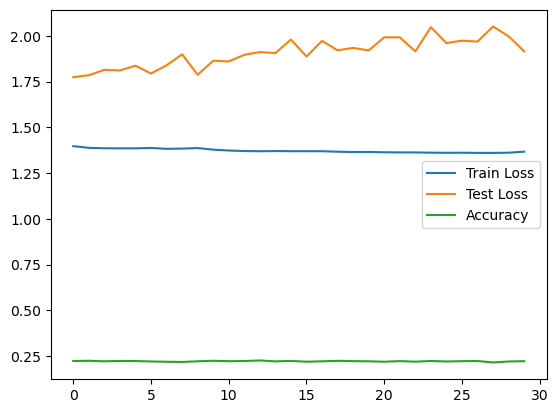

In [24]:
plt.plot(all_train_losses, label='Train Loss')
plt.plot(all_test_losses,  label='Test Loss')
plt.plot(all_accuracies,   label='Accuracy')
plt.legend()
plt.show()